**Imports**

In [1]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, RandRotateD,
    RandFlipD, ToTensorD
)
from monai.data import Dataset, DataLoader, CacheDataset
import monai
from PIL import Image
import nibabel as nib
import pandas as pd
import torch
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import cv2
from monai.transforms import Transform

#!pip install nibabel

num_classes = 4
class_names = ['background', 'RV', 'MY', 'LV']

**Data Collection**

First we collect all the filepaths.

In [2]:
testing_path = '../data/testing/'
training_path = '../data/training/'

def get_acdc_file_paths(data_path):
    original_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??.nii.gz'))
    gt_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz'))

    return original_images, gt_images

training_original_images, training_gt_images = get_acdc_file_paths(training_path)
testing_original_images, testing_gt_images = get_acdc_file_paths(testing_path)

print("Training Original Images:", len(training_original_images))
print("Training GT Images:", len(training_gt_images))
print("Testing Original Images:", len(testing_original_images))
print("Testing GT Images:", len(testing_gt_images))

Training Original Images: 200
Training GT Images: 200
Testing Original Images: 100
Testing GT Images: 100


Then we create a dataframe to store all metadata

In [3]:
# Create a dataframe to store the patient number, frame number, the file path of the image, gt file path and whether it is a training or testing image

def parse_info_file(info_file_path):
    info_dict = {}
    with open(info_file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            info_dict[key] = value if key == 'Group' else float(value) if '.' in value else int(value)
    return info_dict

def get_acdc_file_paths(data_paths):
    data_records = []
    
    for data_path, dataset_type in data_paths:
        # Get all the image and ground truth file paths
        image_pattern = os.path.join(data_path, 'patient*/patient*_frame??.nii.gz')
        gt_pattern = os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz')
        image_paths = glob.glob(image_pattern)
        gt_paths = glob.glob(gt_pattern)

        # Convert gt_paths to a dictionary for quick lookup
        gt_dict = {os.path.basename(gt_path).replace('_gt', ''): gt_path for gt_path in gt_paths}

        for image_path in image_paths:
            basename = os.path.basename(image_path)
            patient_number = basename.split('_')[0].replace('patient', '')
            frame_number = basename.split('_')[1].replace('frame', '').replace('.nii.gz', '')

            # Extracting the directory path to read the info.cfg
            patient_dir = os.path.dirname(image_path)
            info_file_path = os.path.join(patient_dir, 'Info.cfg')
            patient_info = parse_info_file(info_file_path)

            gt_path = gt_dict.get(basename, None)

            data_records.append({
                'patient_number': patient_number,
                'frame_number': frame_number,
                'image_path': image_path,
                'gt_path': gt_path,
                'dataset_type': dataset_type,
                **patient_info  # Add the info.cfg data to the record
            })

    # Create a DataFrame
    df = pd.DataFrame(data_records)

    return df

training_path = '../data/training'
testing_path = '../data/testing'

# Call the function with both paths and their dataset types
data_paths = [(training_path, 'Training'), (testing_path, 'Testing')]
df_metadata = get_acdc_file_paths(data_paths)

# Count the number of entries of each dataset type
counts = df_metadata['dataset_type'].value_counts()
print(counts)


dataset_type
Training    200
Testing     100
Name: count, dtype: int64


In [4]:
df_metadata.head(10)

,patient_number,frame_number,image_path,gt_path,dataset_type,ED,ES,Group,Height,NbFrame,Weight
0,001,01,../data/training/patient001/patient001_frame01...,../data/training/patient001/patient001_frame01...,Training,1,12,DCM,184.0,30,95.0
1,001,12,../data/training/patient001/patient001_frame12...,../data/training/patient001/patient001_frame12...,Training,1,12,DCM,184.0,30,95.0
2,002,01,../data/training/patient002/patient002_frame01...,../data/training/patient002/patient002_frame01...,Training,1,12,DCM,160.0,30,70.0
3,002,12,../data/training/patient002/patient002_frame12...,../data/training/patient002/patient002_frame12...,Training,1,12,DCM,160.0,30,70.0
4,003,01,../data/training/patient003/patient003_frame01...,../data/training/patient003/patient003_frame01...,Training,1,15,DCM,165.0,30,77.0
5,003,15,../data/training/patient003/patient003_frame15...,../data/training/patient003/patient003_frame15...,Training,1,15,DCM,165.0,30,77.0
6,004,01,../data/training/patient004/patient004_frame01...,../data/training/patient004/patient004_frame01...,Training,1,15,DCM,159.0,28,46.0
7,004,15,../data/training/patient004/patient004_frame15...,../data/training/patient004/patient004_frame15...,Training,1,15,DCM,159.0,28,46.0
8,005,01,../data/training/patient005/patient005_frame01...,../data/training/patient005/patient005_frame01...,Training,1,13,DCM,165.0,30,77.0
9,005,13,../data/training/patient005/patient005_frame13...,../data/training/patient005/patient005_frame13...,Training,1,13,DCM,165.0,30,77.0


In [5]:
# Split the DataFrame into training and testing sets
train_df = df_metadata[df_metadata['dataset_type'] == 'Training']
test_df = df_metadata[df_metadata['dataset_type'] == 'Testing']

# Split the testing set into ES and ED stages
test_ed_df = test_df[test_df['frame_number'].astype(int) == test_df['ED']]
test_es_df = test_df[test_df['frame_number'].astype(int) == test_df['ES']]

**Investigate distribution of intensity values and apply histogram equalization**

In [6]:
import torch.nn.functional as F

def one_hot_encode(slice_label, num_classes):
    slice_label = torch.tensor(slice_label, dtype=torch.long)
    one_hot_label = F.one_hot(slice_label, num_classes=num_classes).permute(2, 0, 1)
    return one_hot_label.numpy()

# Convert 3D images to 2D slices
def create_slices_dict(df, num_classes=4):
    slices_dict = []
    for _, row in df.iterrows():
        image_data = nib.load(row['image_path'])
        label_data = nib.load(row['gt_path'])
        
        image = image_data.get_fdata()
        label = label_data.get_fdata()
        
        for i in range(image.shape[-1]):  # Iterate over the slices
            slice_image = image[:, :, i].astype(np.float32)
            slice_image = np.expand_dims(slice_image, axis=0) # from (W, H) to (1, W, H)
            
            slice_label = label[:, :, i].astype(np.float32)       # Classes are 0, 1, 2, 3
            slice_label = np.expand_dims(slice_label, axis=0) # from (W, H) to (1, W, H)
            #slice_label = one_hot_encode(slice_label, num_classes)
            
            pixel_spacing = image_data.header['pixdim'][1:3]
            slice_affine = image_data.affine[:2, :2]
            slice_affine = np.pad(slice_affine, ((0, 1), (0, 1)), mode='constant')
            slice_affine[-1, -1] = 1
            
            meta_dict = {
                'affine': slice_affine,
                'spatial_shape': slice_image.shape,
                'original_channel_dim': 0,
                'slice_number': i,
                'pixdim': pixel_spacing
            }
            
            # Add DataFrame row information to the metadata
            for col in df.columns:
                meta_dict[col] = row[col]

            slices_dict.append({'image': slice_image, 'label': slice_label, 'image_meta_dict': meta_dict, 'mask_meta_dict': meta_dict})
    return slices_dict

training_slices_dict = create_slices_dict(train_df)
testing_slices_dict = create_slices_dict(test_df)

testing_ed_slices_dict = create_slices_dict(test_ed_df)
testing_es_slices_dict = create_slices_dict(test_es_df)

# Define custom transform to load data
# class LoadData(Transform):
#     def __init__(self, keys=None):
#         pass
# 
#     def __call__(self, sample):
#         image = sample['image']
#         mask = sample['label']
# 
#         return {'image': image, 'label': mask, 'image_meta_dict': sample['image_meta_dict'], 'mask_meta_dict': sample['mask_meta_dict']}
from monai.data import MetaTensor

class LoadData(Transform):
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = sample['image']
        mask = sample['label']

        image_meta_dict = sample['image_meta_dict']
        mask_meta_dict = sample['mask_meta_dict']

        # Convert image and mask to MetaTensor with associated metadata
        image = MetaTensor(image, affine=image_meta_dict['affine'])
        mask = MetaTensor(mask, affine=mask_meta_dict['affine'])

        return {'image': image, 'label': mask, 'image_meta_dict': image_meta_dict, 'mask_meta_dict': mask_meta_dict}

Computing histogram: 100%|██████████| 200/200 [00:04<00:00, 40.90it/s]


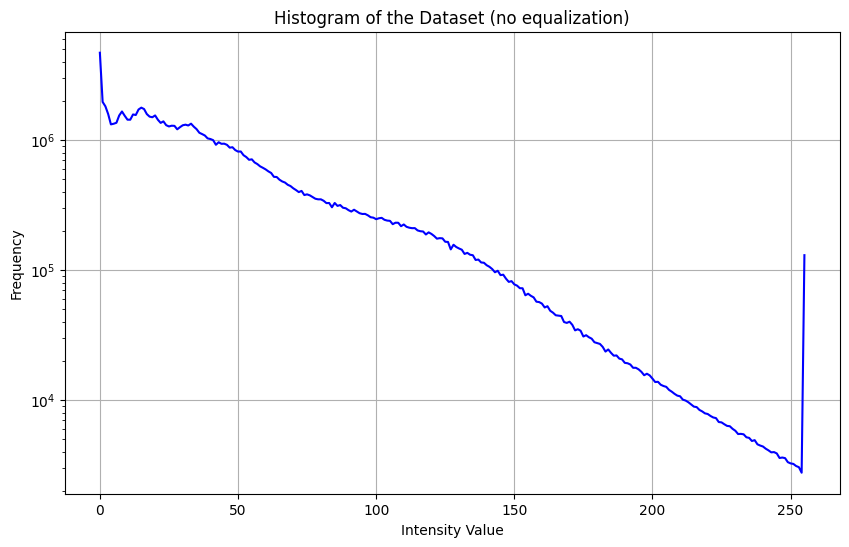

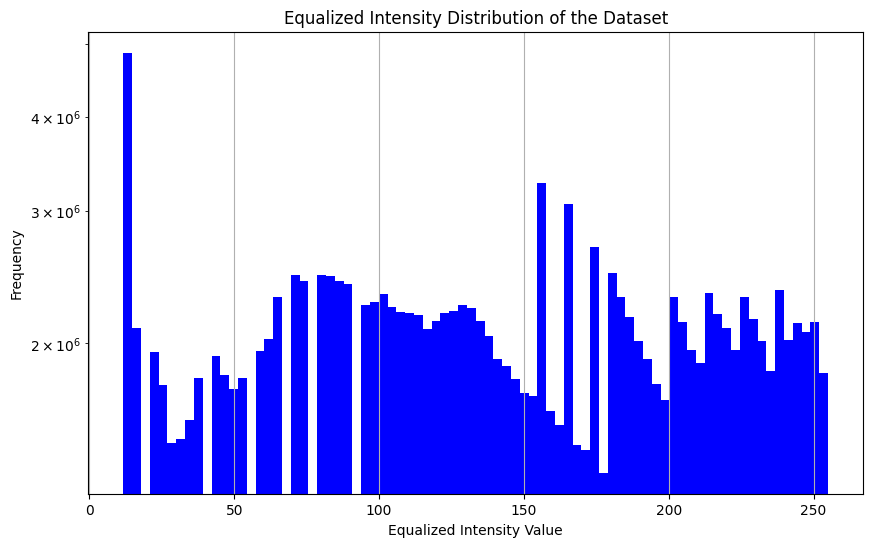

In [7]:
def compute_histogram_and_cdf(df):
    hist = np.zeros(256)

    for image_path in tqdm(df['image_path'], desc="Computing histogram"):
        image = nib.load(image_path).get_fdata()
        image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
        hist += np.histogram(image, bins=256, range=(0, 256))[0]

    cdf = hist.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])  # Normalize CDF to [0, 255]

    return hist, cdf_normalized

# Function to apply histogram equalization using the CDF
def apply_histogram_equalization(image, cdf):
    image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
    equalized_image = cdf[image]
    return equalized_image

# Apply histogram equalization to all images and collect intensity values for visualization
def collect_equalized_intensity_values(df, cdf):
    intensity_values = []

    for image_path in tqdm(df['image_path'], desc="Collecting equalized values"):
        image = nib.load(image_path).get_fdata()
        equalized_image = apply_histogram_equalization(image, cdf)
        intensity_values.extend(equalized_image.flatten())

    return np.array(intensity_values)

# Compute the histogram and CDF of the entire training dataset
hist, cdf = compute_histogram_and_cdf(df_metadata[df_metadata['dataset_type'] == 'Training']) # Note, we only use the training dataset because we don't want to leak information from the testing dataset

# Show the histogram, before equalization
plt.figure(figsize=(10, 6))
plt.plot(hist, color='blue')
plt.title('Histogram of the Dataset (no equalization)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

# Collect equalized intensity values from the DataFrame
equalized_intensity_values = collect_equalized_intensity_values(df_metadata, cdf)

#TODO: remove spikes?

# Plot the histogram of equalized intensity values
plt.figure(figsize=(10, 6))
plt.hist(equalized_intensity_values, bins=80, color='blue')
plt.title('Equalized Intensity Distribution of the Dataset')
plt.xlabel('Equalized Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()


In [8]:
from skimage import exposure

#TODO: Keep old or not?
#TODO: remove code above perhaps

class HistogramEqualization(Transform):
    def __call__(self, sample):
        image = sample['image']

        if isinstance(image, MetaTensor):
            image_data = image.as_tensor()
            image_meta_dict = image.meta
            equalized_image = exposure.equalize_hist(image_data.numpy())  # Normalizes to [0, 1]
            equalized_image = MetaTensor(equalized_image * 255, meta=image_meta_dict)
        else:
            equalized_image = exposure.equalize_hist(image)
            equalized_image = equalized_image * 255 
        sample['image'] = equalized_image
        return sample

Before:  317.1875 350.0
AFter 232.70000000000002 256.1
pixdim after [[-1. -0.  0.]
 [-0. -1.  0.]
 [ 0.  0.  1.]]


/home/jovyan/.local/lib/python3.8/site-packages/monai/transforms/spatial/array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


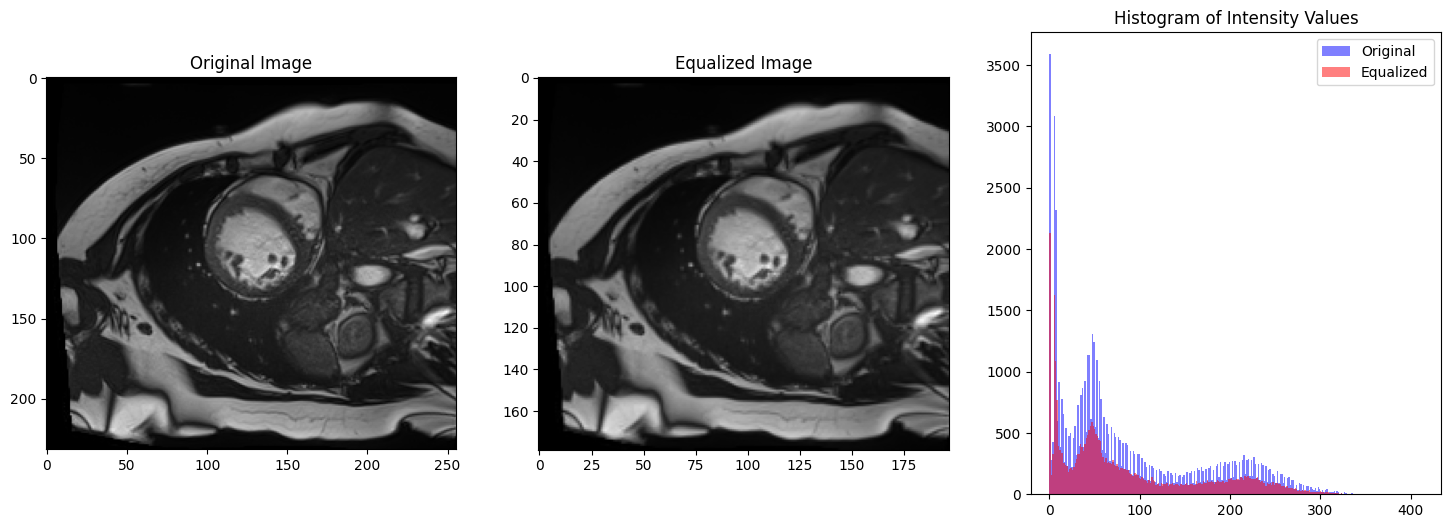

In [9]:
# Test the transformation on a single image and visualize it
sample_image = training_slices_dict[22]['image']
sample_image = sample_image.squeeze()
#sample_image = sample_image[0]
sample_image = np.expand_dims(sample_image, axis=0)

voxel_spacing_before = training_slices_dict[22]['image_meta_dict']['pixdim']
#total size before
print("Before: ", sample_image.shape[1]*voxel_spacing_before[0], sample_image.shape[2]*voxel_spacing_before[1])

new_spacing = (1.3,1.3)
#transform_test = HistogramEqualization()
transform_test = monai.transforms.SpacingD(keys=['image'], pixdim=new_spacing, mode='bilinear')
transformed_data = transform_test({'image': sample_image, 'image_meta_dict': training_slices_dict[22]['image_meta_dict']})
equalized_sample_image = transformed_data['image'].squeeze()

#print total size after
print("AFter", equalized_sample_image.shape[0]*new_spacing[0], equalized_sample_image.shape[1]*new_spacing[1])
print("pixdim after", transformed_data['image_meta_dict']['affine'])

sample_image = sample_image.squeeze()

# Display the original and equalized images along with their histograms
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

# Equalized Image
plt.subplot(1, 3, 2)
plt.imshow(equalized_sample_image, cmap='gray')
plt.title('Equalized Image')

# Histogram of Intensity Values
plt.subplot(1, 3, 3)
plt.hist(sample_image.ravel(), bins=256, color='blue', alpha=0.5, label='Original')
plt.hist(equalized_sample_image.ravel(), bins=256, color='red', alpha=0.5, label='Equalized')
plt.legend(loc='upper right')
plt.title('Histogram of Intensity Values')

plt.show()

In [10]:
# Patch size, should be divisible by 2 repeatedly for UNet
size_y = 128
size_x = 128
pixdim_x = 1.2
pixdim_y = 1.2
# TODO: probably change which transforms to take

class ConvertToFloat32:
    def __call__(self, sample):
        sample['image'] = sample['image'].astype(np.float32)
        sample['label'] = sample['label'].astype(np.float32)
        return sample

train_transform = Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y), mode=['bilinear', 'nearest']),
    monai.transforms.RandRotateD(keys=['image', 'label'], range_x=2 * 3.1415, prob=0.5, mode=['bilinear', 'nearest']),  # Rotate up to 360 degrees
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=0, prob=0.25),  # Flip along x-axis
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=1, prob=0.25),  # Flip along y-axis
    # Add Rand2DElastic transformation
    monai.transforms.Rand2DElasticD(keys=['image', 'label'], spacing=(pixdim_x, pixdim_y), magnitude_range=(0, 1), prob=0.5, mode=['bilinear', 'nearest'], padding_mode='reflection'),  # Elastic deformation
    monai.transforms.RandSpatialCropD(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False),  # Crop patch
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

val_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear', 'nearest']),
    ConvertToFloat32(),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

train_dataset = Dataset(data=training_slices_dict, transform=train_transform) #TODO: split into validation and training set...
test_dataset = Dataset(data=testing_slices_dict, transform=val_transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

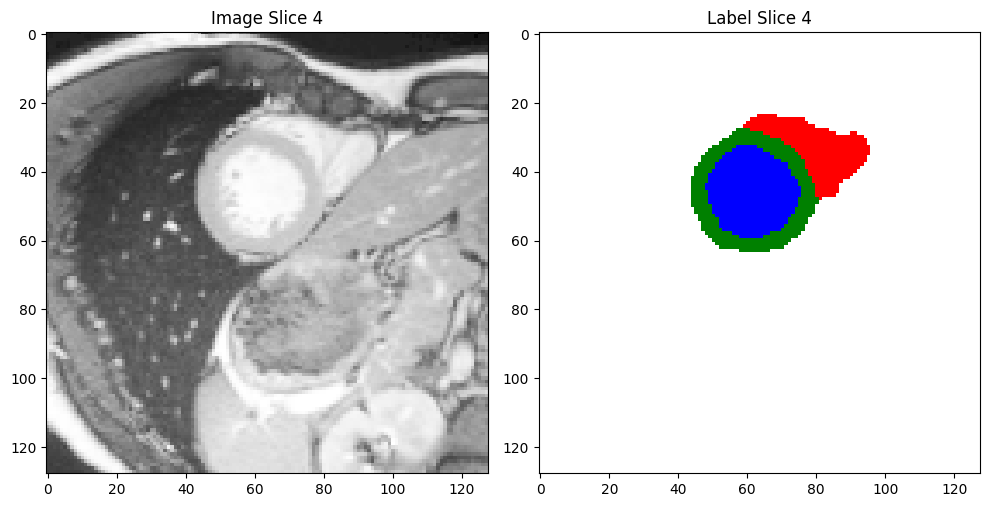

In [11]:
label_cmap = ListedColormap(['none', 'red', 'green', 'blue'])

def visualize_single_sample(data_loader):
    data_batch = next(iter(data_loader))
    batch_index = 0
    image, label = data_batch['image'][batch_index], data_batch['label'][batch_index]
    slice_number = data_batch['image_meta_dict']['slice_number'][batch_index]
    
    #PRINT PIXEL SPACING
    #print(data_batch['image'].meta)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].numpy(), cmap="gray")
    axes[0].set_title(f"Image Slice {slice_number}")
    axes[1].imshow(label[0].numpy(), cmap=label_cmap)
    axes[1].set_title(f"Label Slice {slice_number}")
    plt.tight_layout()
    plt.show()

# Visualize a single sample from the training loader
visualize_single_sample(train_loader)

Setting up the UNet model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [13]:
model = monai.networks.nets.SwinUNETR(
    img_size=(128, 128),  # Adjust this based on the input size of your dataset
    in_channels=1,
    out_channels=4,
    feature_size=48,  # This can be adjusted based on your model capacity needs
    spatial_dims=2,
    use_checkpoint=True,  # Set to True to enable gradient checkpointing for memory savings
).to(device)

#TODO: Try different parameters

/home/jovyan/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [14]:
import wandb

wandb.login()

wandb: Currently logged in as: jsdkoornstra (utwente-jelte). Use `wandb login --relogin` to force relogin


True

In [15]:
def from_compose_to_list(compose_obj):
    return [str(transform) for transform in compose_obj.transforms]

run_name = 'Fourth Run'
run = wandb.init(project='Project - SwinUNETR',
                 name=run_name, 
                 config={'dataset': 'ACDC',
                         'model': 'UNet',
                         'loss function': 'DiceLoss',
                         'optimizer': 'Adam',
                         'transform': from_compose_to_list(train_transform),
                         'batch size': batch_size})

run_id = run.id

In [16]:
def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Transform masks to numpy arrays on CPU
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class labels and insert masks
    class_labels = {0: 'background', 1: 'class1', 2: 'class2', 3: 'class3'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Apply softmax and argmax to the model output
    softmax = torch.nn.Softmax(dim=1)
    outputs = softmax(outputs)
    outputs = torch.argmax(outputs, dim=1)  # Change to dim=1 for batch processing

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [
        wandb.Image(
            img.cpu().numpy().transpose(1, 2, 0),  # Ensure images are in (H, W, C) format
            masks=wandb_masks(mask_output, mask_gt)
        )
        for img, mask_output, mask_gt in zip(batch_data['image'], outputs, batch_data['label'])
    ]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})



**Training the model**

In [17]:
#loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
import torch.nn as nn

# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5):
#         super(CombinedLoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.dice_loss = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
#         self.ce_loss = nn.CrossEntropyLoss()
# 
#     def forward(self, outputs, targets):
#         dice_loss = self.dice_loss(outputs, targets)
#         ce_loss = self.ce_loss(outputs, torch.argmax(targets, dim=1))
#         return self.dice_weight * dice_loss + (1 - self.dice_weight) * ce_loss
# 
# # Usage
# loss_function = CombinedLoss(dice_weight=0.5)

# loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
# Calculate Class Weights (Inverse Frequency)
def calculate_class_weights(labels_list):
    class_counts = {}
    total_pixels = 0

    for labels in labels_list:
        unique_labels, counts = np.unique(labels.flatten(), return_counts=True)
        for label, count in zip(unique_labels, counts):
            class_counts[label] = class_counts.get(label, 0) + count
        total_pixels += labels.size

    class_weights = [total_pixels / (len(class_counts) * class_counts[i]) for i in range(num_classes)]
    return class_weights


train_labels = [data["label"] for data in training_slices_dict]
class_weights = calculate_class_weights(train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
print(class_weights)

# Update Dice Loss with Class Weights
loss_function = monai.losses.DiceLoss(to_onehot_y=True, 
                                     softmax=True,
                                     include_background=True, 
                                     weight=class_weights)
#loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True) #TODO: potentially change this, look for different loss metrics

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

tensor([ 0.2598, 20.6409, 19.2068, 19.6468], device='cuda:0')


In [ ]:
import torch
import os
from tqdm import tqdm

start_epoch = 0
n_epochs = 100
best_models = []
model_name = 'trainedSwinUNETR'

for epoch in range(start_epoch, n_epochs):
    model.train()
    train_loss = 0
    for batch_data in tqdm(train_loader):
        inputs = batch_data['image'].to(device)
        masks = batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            inputs = batch_data['image'].to(device)
            masks = batch_data['label'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'{model_name}_{run_name}_checkpoint_{epoch}_every5.pt')

    # Save the model if it is among the best 3
    if len(best_models) < 3:
        best_models.append((val_loss, epoch))
        best_models.sort()
        torch.save(model.state_dict(), f'{model_name}_{run_name}_checkpoint_{epoch}.pt')
    elif val_loss < best_models[-1][0]:
        # Replace the worst model if current one is better
        _, worst_epoch = best_models.pop()
        best_models.append((val_loss, epoch))
        best_models.sort()
        os.remove(f'{model_name}_{run_name}_checkpoint_{worst_epoch}.pt')
        torch.save(model.state_dict(), f'{model_name}_{run_name}_checkpoint_{epoch}.pt')

# Store the final model
torch.save(model.state_dict(), f'{model_name}_{run_name}.pt')


100%|██████████| 476/476 [02:22<00:00,  3.34it/s]


Epoch 1/100, Train Loss: 9.2978, Validation Loss: 7.4834


100%|██████████| 476/476 [02:19<00:00,  3.42it/s]


Epoch 2/100, Train Loss: 7.3911, Validation Loss: 6.4948


100%|██████████| 476/476 [02:28<00:00,  3.20it/s]


Epoch 3/100, Train Loss: 6.7627, Validation Loss: 6.0472


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 4/100, Train Loss: 6.2536, Validation Loss: 5.6235


100%|██████████| 476/476 [02:24<00:00,  3.28it/s]


Epoch 5/100, Train Loss: 5.7896, Validation Loss: 5.1670


100%|██████████| 476/476 [02:25<00:00,  3.28it/s]


Epoch 6/100, Train Loss: 5.4753, Validation Loss: 4.7946


100%|██████████| 476/476 [02:19<00:00,  3.42it/s]


Epoch 7/100, Train Loss: 5.1983, Validation Loss: 4.6207


100%|██████████| 476/476 [02:28<00:00,  3.21it/s]


Epoch 8/100, Train Loss: 4.9995, Validation Loss: 4.5395


100%|██████████| 476/476 [02:15<00:00,  3.51it/s]


Epoch 9/100, Train Loss: 4.8166, Validation Loss: 4.4194


100%|██████████| 476/476 [02:15<00:00,  3.51it/s]


Epoch 10/100, Train Loss: 4.7172, Validation Loss: 4.3211


100%|██████████| 476/476 [02:15<00:00,  3.50it/s]


Epoch 11/100, Train Loss: 4.6404, Validation Loss: 4.2808


100%|██████████| 476/476 [02:24<00:00,  3.29it/s]


Epoch 12/100, Train Loss: 4.5403, Validation Loss: 4.5381


100%|██████████| 476/476 [02:20<00:00,  3.38it/s]


Epoch 13/100, Train Loss: 4.4298, Validation Loss: 4.0898


100%|██████████| 476/476 [02:20<00:00,  3.40it/s]


Epoch 14/100, Train Loss: 4.3538, Validation Loss: 4.3092


100%|██████████| 476/476 [02:17<00:00,  3.45it/s]


Epoch 15/100, Train Loss: 4.2709, Validation Loss: 4.2949


100%|██████████| 476/476 [02:22<00:00,  3.35it/s]


Epoch 16/100, Train Loss: 4.2814, Validation Loss: 4.0475


100%|██████████| 476/476 [02:31<00:00,  3.14it/s]


Epoch 17/100, Train Loss: 4.2137, Validation Loss: 4.0214


100%|██████████| 476/476 [02:25<00:00,  3.27it/s]


Epoch 18/100, Train Loss: 4.2116, Validation Loss: 3.9919


100%|██████████| 476/476 [02:30<00:00,  3.15it/s]


Epoch 19/100, Train Loss: 4.1830, Validation Loss: 3.9453


100%|██████████| 476/476 [02:56<00:00,  2.70it/s]


Epoch 20/100, Train Loss: 4.1234, Validation Loss: 3.8574


100%|██████████| 476/476 [02:30<00:00,  3.15it/s]


Epoch 21/100, Train Loss: 4.1082, Validation Loss: 3.8326


100%|██████████| 476/476 [02:25<00:00,  3.26it/s]


Epoch 22/100, Train Loss: 4.0339, Validation Loss: 3.8026


100%|██████████| 476/476 [02:23<00:00,  3.32it/s]


Epoch 23/100, Train Loss: 4.1283, Validation Loss: 4.3532


100%|██████████| 476/476 [02:20<00:00,  3.39it/s]


Epoch 24/100, Train Loss: 3.9996, Validation Loss: 3.7436


100%|██████████| 476/476 [02:27<00:00,  3.23it/s]


Epoch 25/100, Train Loss: 3.9316, Validation Loss: 3.8012


100%|██████████| 476/476 [02:23<00:00,  3.32it/s]


Epoch 26/100, Train Loss: 3.9775, Validation Loss: 3.8925


100%|██████████| 476/476 [02:19<00:00,  3.40it/s]


Epoch 27/100, Train Loss: 3.9539, Validation Loss: 3.8542


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 28/100, Train Loss: 3.9865, Validation Loss: 3.8553


100%|██████████| 476/476 [02:19<00:00,  3.41it/s]


Epoch 29/100, Train Loss: 3.9101, Validation Loss: 3.7048


100%|██████████| 476/476 [02:25<00:00,  3.27it/s]


Epoch 30/100, Train Loss: 3.8691, Validation Loss: 3.6898


100%|██████████| 476/476 [02:15<00:00,  3.52it/s]


Epoch 31/100, Train Loss: 3.8597, Validation Loss: 3.6979


100%|██████████| 476/476 [02:16<00:00,  3.48it/s]


Epoch 32/100, Train Loss: 3.8549, Validation Loss: 3.6161


100%|██████████| 476/476 [02:17<00:00,  3.46it/s]


Epoch 33/100, Train Loss: 3.7990, Validation Loss: 3.7470


100%|██████████| 476/476 [02:36<00:00,  3.05it/s]


Epoch 34/100, Train Loss: 3.8256, Validation Loss: 3.7263


100%|██████████| 476/476 [02:23<00:00,  3.31it/s]


Epoch 35/100, Train Loss: 3.7895, Validation Loss: 3.8145


100%|██████████| 476/476 [02:18<00:00,  3.44it/s]


Epoch 36/100, Train Loss: 3.8221, Validation Loss: 3.8195


100%|██████████| 476/476 [02:27<00:00,  3.22it/s]


Epoch 37/100, Train Loss: 3.7685, Validation Loss: 3.7613


100%|██████████| 476/476 [02:24<00:00,  3.28it/s]


Epoch 38/100, Train Loss: 3.7529, Validation Loss: 3.5806


100%|██████████| 476/476 [02:35<00:00,  3.07it/s]


Epoch 39/100, Train Loss: 3.7386, Validation Loss: 3.5964


100%|██████████| 476/476 [02:28<00:00,  3.20it/s]


Epoch 40/100, Train Loss: 3.7269, Validation Loss: 3.5610


100%|██████████| 476/476 [02:30<00:00,  3.16it/s]


Epoch 41/100, Train Loss: 3.7361, Validation Loss: 3.6106


100%|██████████| 476/476 [02:32<00:00,  3.13it/s]


Epoch 42/100, Train Loss: 3.6964, Validation Loss: 3.6680


100%|██████████| 476/476 [02:31<00:00,  3.15it/s]


Epoch 43/100, Train Loss: 3.7929, Validation Loss: 3.6281


100%|██████████| 476/476 [02:26<00:00,  3.26it/s]


Epoch 44/100, Train Loss: 3.7185, Validation Loss: 3.6093


100%|██████████| 476/476 [02:24<00:00,  3.29it/s]


Epoch 45/100, Train Loss: 3.7378, Validation Loss: 3.6030


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 46/100, Train Loss: 3.6324, Validation Loss: 3.6246


100%|██████████| 476/476 [02:37<00:00,  3.02it/s]


Epoch 47/100, Train Loss: 3.7043, Validation Loss: 3.6056


100%|██████████| 476/476 [02:25<00:00,  3.27it/s]


Epoch 48/100, Train Loss: 3.6235, Validation Loss: 3.5718


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 49/100, Train Loss: 3.6268, Validation Loss: 3.5441


100%|██████████| 476/476 [02:23<00:00,  3.31it/s]


Epoch 50/100, Train Loss: 3.6564, Validation Loss: 3.6320


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 51/100, Train Loss: 3.5692, Validation Loss: 3.6770


100%|██████████| 476/476 [02:31<00:00,  3.14it/s]


Epoch 52/100, Train Loss: 3.5667, Validation Loss: 3.6149


100%|██████████| 476/476 [02:31<00:00,  3.13it/s]


Epoch 53/100, Train Loss: 3.5992, Validation Loss: 3.5490


100%|██████████| 476/476 [02:31<00:00,  3.14it/s]


Epoch 54/100, Train Loss: 3.5889, Validation Loss: 3.4908


100%|██████████| 476/476 [02:19<00:00,  3.41it/s]


Epoch 55/100, Train Loss: 3.6185, Validation Loss: 3.6130


100%|██████████| 476/476 [02:32<00:00,  3.13it/s]


Epoch 56/100, Train Loss: 3.5429, Validation Loss: 3.6262


100%|██████████| 476/476 [02:30<00:00,  3.17it/s]


Epoch 57/100, Train Loss: 3.5470, Validation Loss: 3.5436


100%|██████████| 476/476 [02:24<00:00,  3.28it/s]


Epoch 58/100, Train Loss: 3.5874, Validation Loss: 3.5439


100%|██████████| 476/476 [02:24<00:00,  3.30it/s]


Epoch 59/100, Train Loss: 3.5042, Validation Loss: 3.5410


100%|██████████| 476/476 [02:36<00:00,  3.05it/s]


Epoch 60/100, Train Loss: 3.5248, Validation Loss: 3.4316


100%|██████████| 476/476 [02:27<00:00,  3.24it/s]


Epoch 61/100, Train Loss: 3.5536, Validation Loss: 3.6008


100%|██████████| 476/476 [02:31<00:00,  3.13it/s]


Epoch 62/100, Train Loss: 3.6240, Validation Loss: 3.5487


100%|██████████| 476/476 [02:21<00:00,  3.36it/s]


Epoch 63/100, Train Loss: 3.6620, Validation Loss: 3.5190


100%|██████████| 476/476 [02:49<00:00,  2.81it/s]


Epoch 64/100, Train Loss: 3.5668, Validation Loss: 3.5428


100%|██████████| 476/476 [02:28<00:00,  3.21it/s]


Epoch 65/100, Train Loss: 3.6024, Validation Loss: 3.5233


100%|██████████| 476/476 [02:24<00:00,  3.29it/s]


Epoch 66/100, Train Loss: 3.6277, Validation Loss: 3.6406


100%|██████████| 476/476 [02:26<00:00,  3.25it/s]


Epoch 67/100, Train Loss: 3.6303, Validation Loss: 3.6745


100%|██████████| 476/476 [02:27<00:00,  3.22it/s]


Epoch 68/100, Train Loss: 3.7497, Validation Loss: 3.5456


100%|██████████| 476/476 [02:44<00:00,  2.89it/s]


Epoch 69/100, Train Loss: 3.5595, Validation Loss: 3.5575


100%|██████████| 476/476 [02:31<00:00,  3.13it/s]


Epoch 70/100, Train Loss: 3.7694, Validation Loss: 3.7171


100%|██████████| 476/476 [02:39<00:00,  2.99it/s]


Epoch 71/100, Train Loss: 3.9467, Validation Loss: 3.5818


100%|██████████| 476/476 [02:28<00:00,  3.20it/s]


Epoch 72/100, Train Loss: 3.6139, Validation Loss: 3.4133


100%|██████████| 476/476 [02:23<00:00,  3.33it/s]


Epoch 73/100, Train Loss: 3.8813, Validation Loss: 3.5033


100%|██████████| 476/476 [02:42<00:00,  2.93it/s]


Epoch 74/100, Train Loss: 3.6029, Validation Loss: 3.8913


100%|██████████| 476/476 [02:23<00:00,  3.33it/s]


Epoch 75/100, Train Loss: 3.7785, Validation Loss: 3.8429


100%|██████████| 476/476 [02:19<00:00,  3.41it/s]


Epoch 76/100, Train Loss: 3.6731, Validation Loss: 3.4684


100%|██████████| 476/476 [06:06<00:00,  1.30it/s]


Epoch 77/100, Train Loss: 3.8886, Validation Loss: 3.6852


100%|██████████| 476/476 [09:42<00:00,  1.22s/it]


Epoch 78/100, Train Loss: 3.8008, Validation Loss: 3.7278


100%|██████████| 476/476 [12:13<00:00,  1.54s/it]


In [ ]:
run.finish()

In [18]:
#TODO: load saved model for evaluation

#load model from model_saves .pt file

model.load_state_dict(torch.load('trainedSwinUNETR_Fourth Run_checkpoint_59.pt'))

<All keys matched successfully>

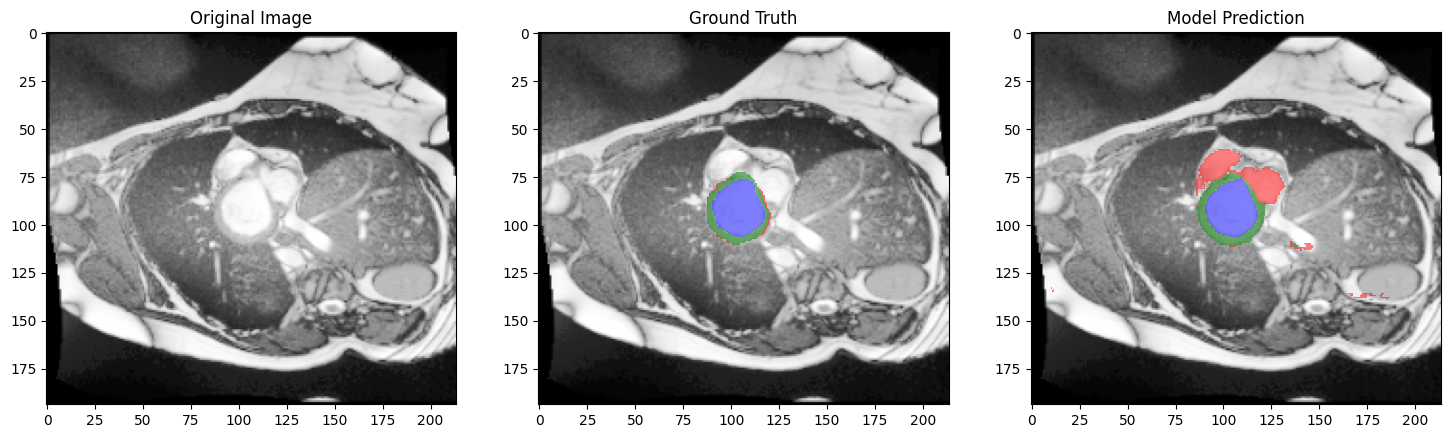

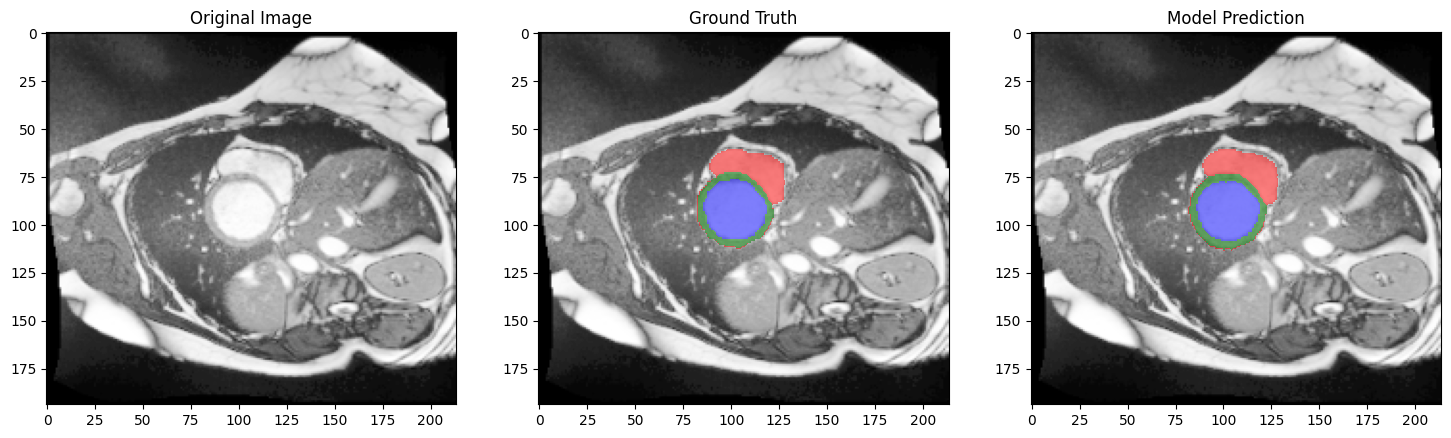

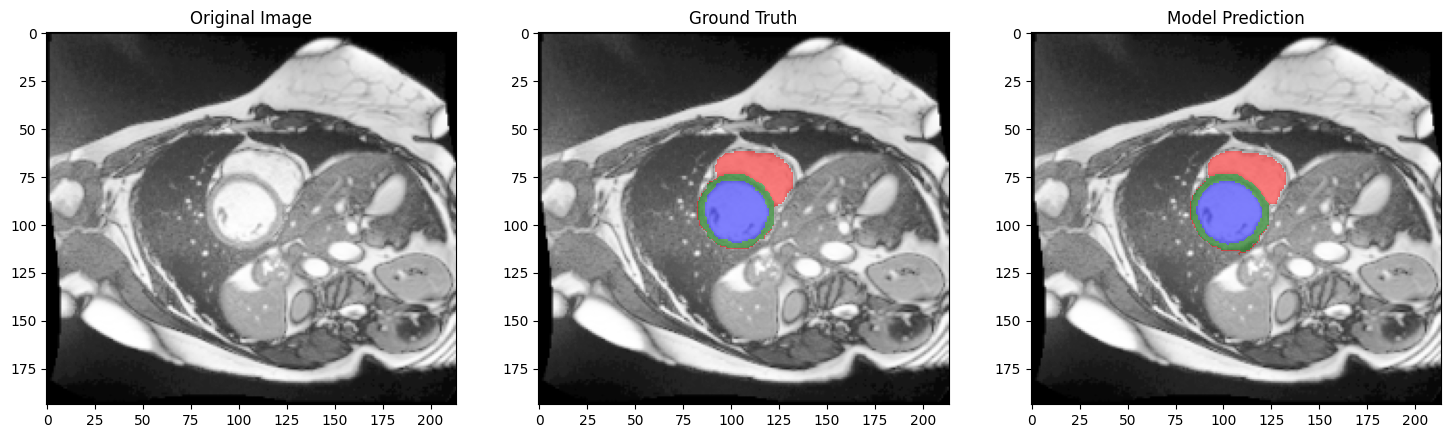

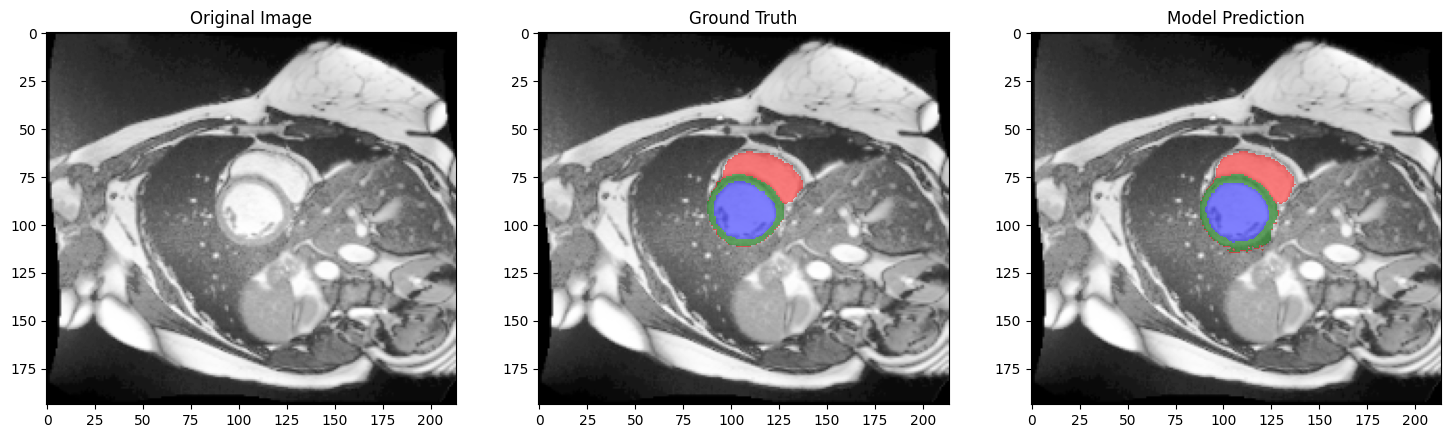

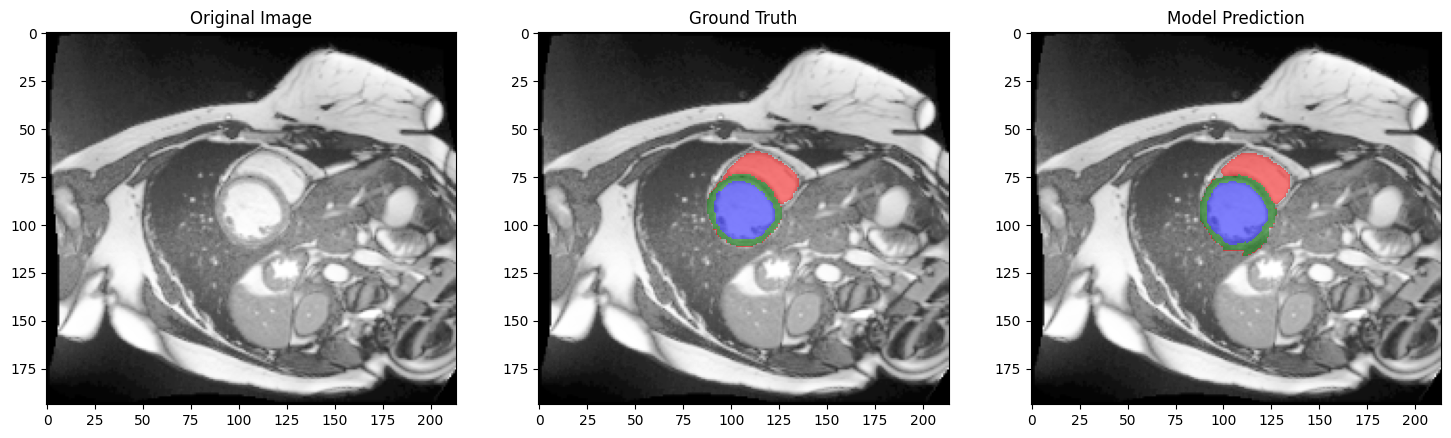

In [20]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the image, the ground truth,
    and the segmentation map produced by the network.
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an image ('image') and a mask ('label').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[size_x, size_y]) 
    softmax = torch.nn.Softmax(dim=1)

    # Ensure the input is float32
    sample_image = sample['image'].to(device)
    #check if image is float or double
    #print(sample_image.dtype)

    with torch.no_grad():
        output = softmax(inferer(sample_image, network=model)).squeeze()

    # Convert the ground truth and prediction to the format suitable for visualization
    #torch.Size([1, 1, 232, 256])
    #convert to 232, 256
    ground_truth = sample['label'].squeeze().numpy()
    #ground_truth = torch.argmax(sample['label'].squeeze(), dim=0).numpy()
    predicted_label = torch.argmax(output, dim=0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=[18, 6])

    # Plot original image
    ax[0].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[0].set_title('Original Image')

    # Plot ground truth
    ax[1].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[1].imshow(ground_truth, cmap=label_cmap, alpha=0.5)
    ax[1].set_title('Ground Truth')

    # Plot model prediction
    ax[2].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[2].imshow(predicted_label, cmap=label_cmap, alpha=0.5)
    ax[2].set_title('Model Prediction')

    plt.show()
    
test_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear', 'nearest']),
    ConvertToFloat32(),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

test_dataset = Dataset(data=testing_slices_dict, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1)

test_ed_dataset = Dataset(data=testing_ed_slices_dict, transform=test_transform)
test_ed_loader = DataLoader(test_ed_dataset, batch_size=1)

test_es_dataset = Dataset(data=testing_es_slices_dict, transform=test_transform)
test_es_loader = DataLoader(test_es_dataset, batch_size=1)

i = 0
for sample in test_loader:
    visual_evaluation(sample, model)
    i += 1
    if i == 5:
        break


**Evaluation Metrics**

In [21]:
from monai.metrics import DiceMetric, HausdorffDistanceMetric

def compute_metric(dataloader, model, metric_fn, num_classes):

    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[size_x, size_y])
    softmax = torch.nn.Softmax(dim=1)

    metric_values = []

    for sample in tqdm(dataloader, desc="Evaluating"):
        with torch.no_grad():
            output = softmax(inferer(sample['image'].to(device), network=model)).cpu()
            predicted_label = torch.argmax(output, dim=1)  # Shape: (B, H, W)

        # Add batch dimension to match the expected input format
        predicted_label = predicted_label.unsqueeze(1)  # Shape: (B, 1, H, W)
        ground_truth_label = sample["label"]  # Shape: (B, 1, H, W)

        # Ensure the values are in the correct format for multi-class Dice computation
        predicted_label = torch.nn.functional.one_hot(predicted_label.squeeze(1), num_classes=num_classes).permute(0, 3, 1, 2).float()
        ground_truth_label = torch.nn.functional.one_hot(ground_truth_label.squeeze(1).long(), num_classes=num_classes).permute(0, 3, 1, 2).float()

        metric_fn(y_pred=predicted_label, y=ground_truth_label)
        batch_metric_value = metric_fn.aggregate(reduction="none").cpu().numpy()
        metric_values.append(batch_metric_value)
        metric_fn.reset()

        #print(f"Batch Metric: {batch_metric_value}")

    # Calculate mean per class
    metric_values = torch.tensor(metric_values)
    metric_values[torch.isinf(metric_values)] = float('nan')
    mean_metric_per_class = metric_values.nanmean(dim=0).numpy()

    return mean_metric_per_class

In [22]:
dice_metric = DiceMetric(include_background=True, reduction="mean_channel", num_classes=num_classes, ignore_empty=True)
hausdorff_metric = HausdorffDistanceMetric(include_background=True)

#Get metrics for ED and ES
mean_dice_per_class_ed = compute_metric(test_ed_loader, model, dice_metric, num_classes)
mean_dice_per_class_es = compute_metric(test_es_loader, model, dice_metric, num_classes)
hausdorff_values_ed = compute_metric(test_ed_loader, model, hausdorff_metric, num_classes)
hausdorff_values_es = compute_metric(test_es_loader, model, hausdorff_metric, num_classes)

Evaluating: 100%|██████████| 538/538 [01:24<00:00,  6.39it/s]
/tmp/ipykernel_3038/2844600774.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  metric_values = torch.tensor(metric_values)
Evaluating:   0%|          | 0/538 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
Evaluating:   3%|▎         | 17/538 [00:02<01:10,  7.41it/s]/home/jovyan/.local/lib/python3.8/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/jovyan/.local/lib/python3.8/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 3 is all

In [23]:
# Create a DataFrame to store the evaluation results
results = pd.DataFrame({'Class': class_names, 'Mean Dice ED': mean_dice_per_class_ed[0], 'Mean Dice ES': mean_dice_per_class_es[0], 'Hausdorff ED': hausdorff_values_ed[0], 'Hausdorff ES': hausdorff_values_es[0]})
results = results[results['Class'] != 'background'] # Remove the background class, since the leaderboard does not include it

#save results to csv
results.to_csv('results.csv', index=False, decimal=',', sep=';')
results

,Class,Mean Dice ED,Mean Dice ES,Hausdorff ED,Hausdorff ES
1,RV,0.869076,0.802157,36.015217,37.503067
2,MY,0.825492,0.847640,14.771599,17.129810
3,LV,0.926934,0.888796,7.458994,8.663342
